# Introduction

 There are two main sources of law in the American legal system. There are the constitutions and laws passed by Federal and State legislatures, and there are the rulings passed by various courts. The job of the courts is to interpret the law, describe the situations where they apply and account for situations that the statutes themselves do not account for. 
 
Given that in addition to the Supreme Court there are 13 Federal Appellate courts, 50 State Supreme Courts and innumrable smaller courts that issue opinions of precedntial weight, the body of legal authority utilized in the practice of law is absolutely massive. 
 
Keeping this information sorted for easy retreival is no easy task. It is in fact arguably one of the oldest database design challenges in modern times. Proprietary indexing systems exist to facilicate the retreival of precedents relevant to a particular problem, most notably the West Key numbering system.https://en.m.wikipedia.org/wiki/West_American_Digest_System, which has been around for a hundered years. 
 
As you can imagine, categorizing the massive body of newly issued court opinions is no easy task. You need lawyers or at least those with sufficient training to understand the discussions in a given opinion in order to properly assign to them the relevant category labels. And since there are hundered of courts each churning out hundereds of opinions every year, you can imagine what an enormous ongoing enterprise this is. It is the reason why services like Westlaw and Lexis are so expensive and comprise a large portion of a law firms budget, especially smaller firms. 
 
This is where NLP comes in. If we can develop machine learning models that can accurately label newly published legal opinions, we can save thousands of hours of expensive labor hours that we would otherwise need if we continued to rely on teams of Attorneys to perform this labeling. This can in turn lead to enormous savings in the cost of legal services which will help clients save money and increase peoples access to legal representation and promote greater justice in society.
 
In this project we seek to build a model that can accurately classify a given Supreme Court opinion into the area of law it pertains to. We will try different approaches and see what yields the best results.  Since it is difficult to acquire the full texts of court opinions in aggregate, we are going to focus on just the Supreme Court for now. If we are able to model Supreme Court opinions with sufficient reliability, we 
will have an indication of the feasibility of using NLP classification techniques to classify the opinions of other courts as well.

#Preliminary Steps

## Import Libraries

In [ ]:
# Imports

!pip install datashop
!pip install textdistance
!pip install h5py

import pandas as pd
import numpy as np
import scipy as sp
import json

import random
random.seed(11)
import math
from matplotlib import cycler
import matplotlib.pyplot as plt
#import textdistance
import matplotlib as mpl
from datashop_classes import *

import os
import glob

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import nltk
from nltk import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction import text as sk_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
 
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Set default plotting styles

In [ ]:
colors = cycler('color',
                ['#434343'])
plt.rc('axes', facecolor='#eeeeee', edgecolor='#434343',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='#434343',labelsize=14)
plt.rc('ytick', direction='out', color='#434343',labelsize=14)
plt.rc('patch', facecolor='#eeeeee',edgecolor='#eeeeee')
plt.rc('lines', color='#434343',linewidth=1)
mpl.rcParams["figure.facecolor"] = '#eeeeee'
mpl.rcParams['figure.figsize'] = (16,9)

# Exploration


## Load Data

### Opinion text

An dataset containing the full text of Supreme Court Case opinions aggregated in a tabular form is hard to find. Garrett Fiddler was kind enough to compile such a dataset from the [CourtListener API](https://www.courtlistener.com/api/) and upload it to Kaggle. 

In [ ]:
df_fiddler = pd.read_csv(PROJECT_PATH+'/data/fiddler_all_opinions.csv')

# Add a prefix to columns to track of which dataset the feature is from
df_fiddler = df_fiddler.add_prefix('fd_')

#df_fiddler= df_fiddler[~df_fiddler['federal_cite_one'].isna()]

### Labels

Unfortunately, the CourtListener database did not contain the kind of category labels we are hoping to model. For that, we will turn to the University of Washington [Supreme Court Database Project](http://scdb.wustl.edu/data.php). Here we can find a dataset with granular details for Supreme Court cases. We selected the [case centered set](http://scdb.wustl.edu/_brickFiles/2019_01/SCDB_2019_01_caseCentered_Citation.csv.zip) and load it in. The labels we are interested in are in the issueArea column.

In [ ]:
df_uwash = pd.read_csv(PROJECT_PATH+'/data/uwash_case.csv',encoding='latin')

# Add a prefix to columns to track of which dataset the feature is from
df_uwash = df_uwash.add_prefix('uw_')

#convert the date column to datetime
df_uwash['uw_dateDecision'] = pd.to_datetime(df_uwash['uw_dateDecision'])

# Drop rows that dont have a label category
df_uwash= df_uwash[~df_uwash['uw_issueArea'].isna()]


### Merge dataset

Interestingly enough, the court listener dataset seems to have an "scdb_id" column that seems to serve as a foreign key for the U-Washington dataset. Mergeing the datasets on this column returns in a high number of matches

In [ ]:
df_main = df_fiddler.merge(
    df_uwash,
    left_on='fd_scdb_id',
    right_on = 'uw_caseId',
    how='inner'
)

In [ ]:
df_main.head(30)

,fd_author_name,fd_category,fd_per_curiam,fd_case_name,fd_date_filed,fd_federal_cite_one,fd_absolute_url,fd_cluster,fd_year_filed,fd_scdb_id,fd_scdb_decision_direction,fd_scdb_votes_majority,fd_scdb_votes_minority,fd_text,uw_caseId,uw_docketId,uw_caseIssuesId,uw_voteId,uw_dateDecision,uw_decisionType,uw_usCite,uw_sctCite,uw_ledCite,uw_lexisCite,uw_term,uw_naturalCourt,uw_chief,uw_docket,uw_caseName,uw_dateArgument,uw_dateRearg,uw_petitioner,uw_petitionerState,uw_respondent,uw_respondentState,uw_jurisdiction,uw_adminAction,uw_adminActionState,uw_threeJudgeFdc,uw_caseOrigin,uw_caseOriginState,uw_caseSource,uw_caseSourceState,uw_lcDisagreement,uw_certReason,uw_lcDisposition,uw_lcDispositionDirection,uw_declarationUncon,uw_caseDisposition,uw_caseDispositionUnusual,uw_partyWinning,uw_precedentAlteration,uw_voteUnclear,uw_issue,uw_issueArea,uw_decisionDirection,uw_decisionDirectionDissent,uw_authorityDecision1,uw_authorityDecision2,uw_lawType,uw_lawSupp,uw_lawMinor,uw_majOpinWriter,uw_majOpinAssigner,uw_splitVote,uw_majVotes,uw_minVotes
0,justice roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,134 S. Ct. 1434,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...,2013-033,2013-033-01,2013-033-01-01,2013-033-01-01-01,2014-04-02,7,NaN,134 S. Ct. 1434,188 L. Ed. 2d 468,2014 U.S. LEXIS 2391,2013,1704,Roberts,12-536,MCCUTCHEON v. FEC,10/8/2013,NaN,211,NaN,343.0,NaN,2,42.0,NaN,1.0,55.0,NaN,55.0,NaN,0.0,1.0,9.0,2.0,2.0,4.0,0.0,1.0,0.0,0.0,30140.0,3.0,1.0,0.0,1.0,7.0,2.0,200.0,NaN,111.0,111.0,1,5,4
1,justice thomas,concurring,False,McCutcheon v. Federal Election Comm'n,2014-04-02,134 S. Ct. 1434,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...,2013-033,2013-033-01,2013-033-01-01,2013-033-01-01-01,2014-04-02,7,NaN,134 S. Ct. 1434,188 L. Ed. 2d 468,2014 U.S. LEXIS 2391,2013,1704,Roberts,12-536,MCCUTCHEON v. FEC,10/8/2013,NaN,211,NaN,343.0,NaN,2,42.0,NaN,1.0,55.0,NaN,55.0,NaN,0.0,1.0,9.0,2.0,2.0,4.0,0.0,1.0,0.0,0.0,30140.0,3.0,1.0,0.0,1.0,7.0,2.0,200.0,NaN,111.0,111.0,1,5,4
2,justice breyer,dissenting,False,McCutcheon v. Federal Election Comm'n,2014-04-02,134 S. Ct. 1434,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U...",2013-033,2013-033-01,2013-033-01-01,2013-033-01-01-01,2014-04-02,7,NaN,134 S. Ct. 1434,188 L. Ed. 2d 468,2014 U.S. LEXIS 2391,2013,1704,Roberts,12-536,MCCUTCHEON v. FEC,10/8/2013,NaN,211,NaN,343.0,NaN,2,42.0,NaN,1.0,55.0,NaN,55.0,NaN,0.0,1.0,9.0,2.0,2.0,4.0,0.0,1.0,0.0,0.0,30140.0,3.0,1.0,0.0,1.0,7.0,2.0,200.0,NaN,111.0,111.0,1,5,4
3,per_curiam,per_curiam,True,Niukkanen v. McAlexander,1960-06-06,362 U.S. 390,https://www.courtlistener.com/opinion/106035/n...,https://www.courtlistener.com/api/rest/v3/clus...,1960,1959-064,1.0,5.0,4.0,The petitioner sought relief from an order dir...,1959-064,1959-064-01,1959-064-01-01,1959-064-01-01-01,1960-04-18,6,362 U.S. 390,80 S. Ct. 799,4 L. Ed. 2d 816,1960 U.S. LEXIS 1304,1959,1406,Warren,130,"NIUKKANEN, ALIAS MACKIE, v. MCALEXANDER, ACTIN...",3/21/1960,NaN,106,NaN,368.0,NaN,1,7.0,NaN,0.0,108.0,NaN,29.0,NaN,0.0,12.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,20110.0,2.0,1.0,0.0,4.0,NaN,3.0,369.0,NaN,NaN,80.0,1,5,4
4,justice douglas,dissenting,True,Niukkanen v. McAlexander,1960-06-06,362 U.S. 390,https://www.courtlistener.com/opinion/106035/n...,https://www.courtlistener.com/api/rest/v3/clus...,1960,1959-064,1.0,5.0,4.0,"Petitioner was born in Finland in 1908, came h...",1959-064,1959-064-01,1959-064-01-01,1959-064-01-01-01,1960-04-18,6,362 U.S. 390,80 S. Ct. 799,4 L. Ed. 2d 816,1960 U.S. LEXIS 1304,1959,1406,Warren,130,"NIUKKANEN, ALIAS MACKIE, v. MCALEXANDER, ACTIN...",3/21/1960,NaN,106,NaN,368.0,NaN,1,7.0,N

Lets save the merged dataset as a csv for later convenience.

In [ ]:
df_main.to_csv(PROJECT_PATH+'/data/LabeledOpinionsGOOGLE.csv')

## Opinion Lengths


Lets take a look at the distribution of the lengths of each opinions. 

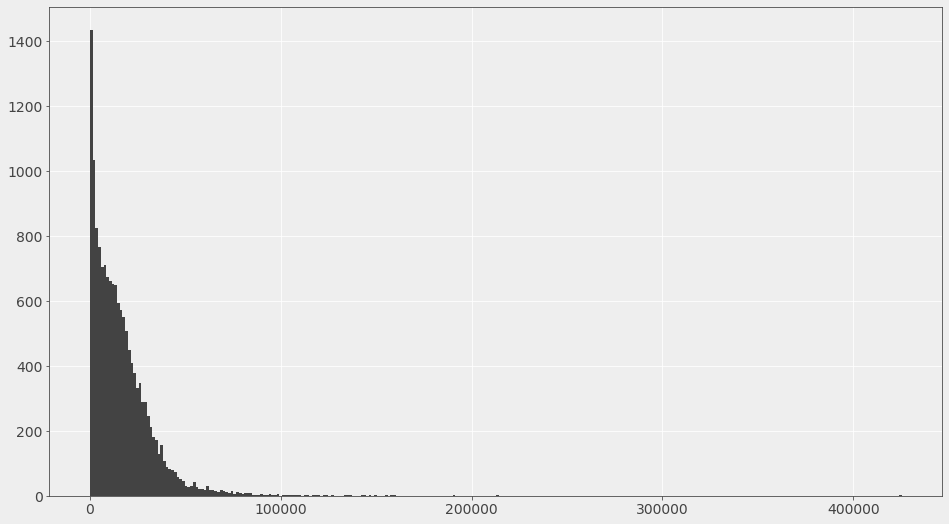

In [ ]:
df_main['text_len'] = df_main['fd_text'].apply(lambda x: len(x))
df_main.text_len.hist(bins=300)

Looks like we have some outlying values, but most of out opinions are less than 100,000 charachters long. 

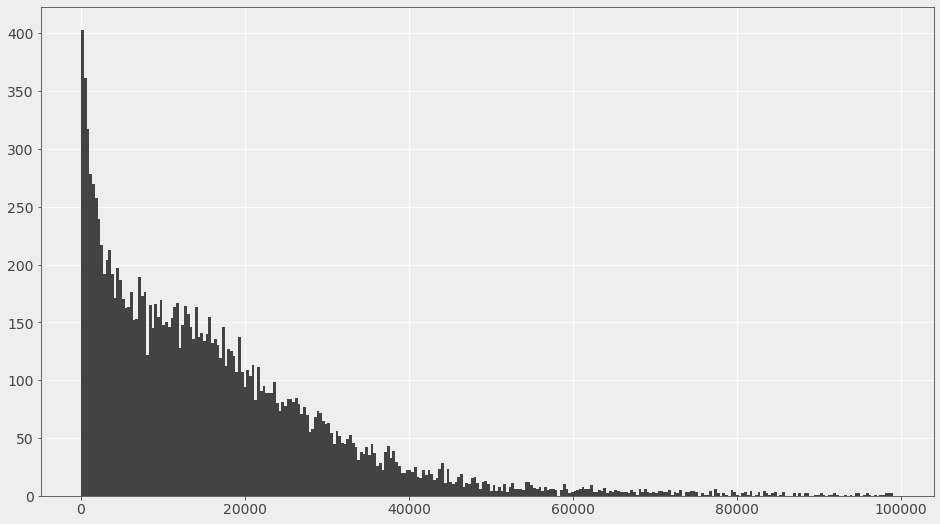

In [ ]:
opinion_lengths = df_main[df_main['text_len'] < 100000]['text_len']
opinion_lengths.hist(bins=300)

We seem to have an unusually large number of opinions that are less than about 2000 charachters. I suspect these are per curiam opinions and sumamry dismissals that do not have any substantive discussion. These will not be useful in building out model and may introduce noise. Lets see if this is true.

In [ ]:
df_sub2k = df_main[df_main['text_len'] < 2000].sort_values(by='text_len')['fd_text']
display(df_sub2k.head(20))

13914    The writ of certiorari is dismissed as improvi...
8613     The writ of certiorari is dismissed as improvi...
3287     The judgment below is affirmed by an equally d...
9239     The writ of certiorari is dismissed as improvi...
2197     The writ of certiorari is dismissed as improvi...
13126    The writ of certiorari is dismissed as improvi...
249      The writ of certiorari is dismissed as improvi...
1545     The writ of certiorari is dismissed as improvi...
8102     The writ of certiorari is dismissed as improvi...
2693     The writ of certiorari is dismissed as improvi...
7946     The writ of certiorari is dismissed as improvi...
4688     The writ of certiorari is dismissed as improvi...
9171     The writ of certiorari is dismissed as improvi...
8479     The writ of certiorari is dismissed as improvi...
12552    The writ of certiorari is dismissed as improvi...
8019     The writ of certiorari is dismissed as improvi...
379      The writ of certiorari is dismissed as improvi.

Looks like our hunch was correct. To be safe, lets remove all opinions less than 5000 charachters and more than 85,000 charachters. 

In [ ]:
df_main = df_main[
                    (df_main['text_len'] >5000) & 
                    (df_main['text_len'] < 85000) ]


Looks like we still have 6567 opinions left.

## Label Distribution

Looking at the [documentation](http://scdb.wustl.edu/documentation.php?var=issueArea) for the U-Wash label data, we see that the categories are recorded as numbers in the actual dataset. It makes more sense to map these numbers to the actual names of the categories. 

In [ ]:
label_map = {
    1:'Criminal Procedure',
    2:'Civil Rights',
    3:'First Amendment',
    4:'Due Process',
    5:'Privacy',
    6:'Attorneys',
    7:'Unions',
    8:'Economic Activity',
    9:'Judicial Power',
    10:'Federalism',
    11:'Interstate Relations',
    12:'Federal Taxation',
    13:'Miscellaneous',
    14:'Private Action'
    }

df_main['labels'] = df_main['uw_issueArea'].replace(label_map)

Now lets take a look at how the labels are distributed

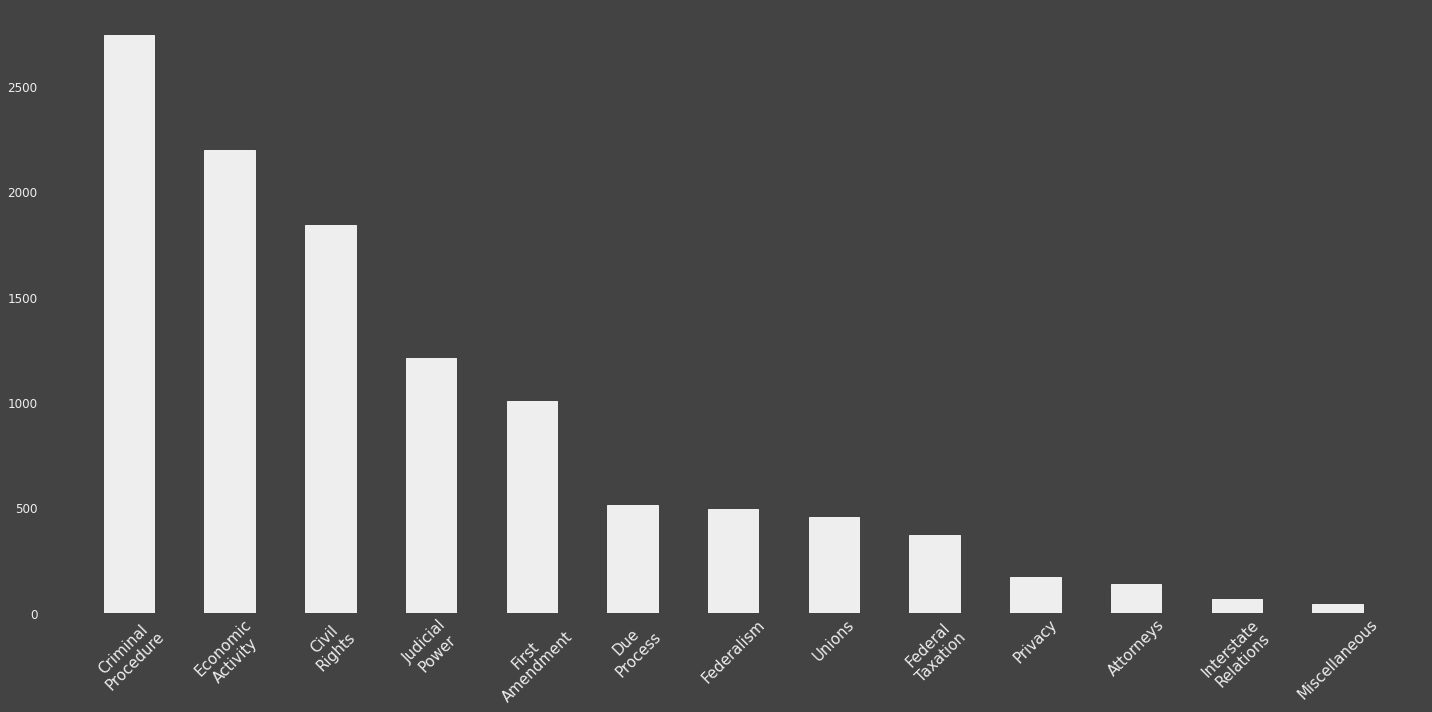

In [ ]:
sr_labels = df_main['labels'].value_counts()

fig,ax = plt.subplots(
    figsize=(20,10),
    facecolor='#434343')

ax.set_facecolor('#434343')


ax.bar(
    list(sr_labels.index),
    sr_labels,
    width = 0.5,
    facecolor='#eeeeee',
    edgecolor='#eeeeee'
    )

fig.canvas.draw()

xlabels_new = [label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()]

ax.set_xticklabels(xlabels_new)

ax.tick_params(
    axis='x', 
    colors='#eeeeee',
    labelsize=15,
    labelrotation=45,
    length=0
    )

ax.tick_params(
    axis='y', 
    colors='#eeeeee',
    labelsize=12,
    length=0
    )


ax.spines['bottom'].set_color('#434343')
ax.spines['left'].set_color('#434343')
ax.grid(color='#434343')
fig.tight_layout()

fig.savefig('images/LabelDistribution.png',facecolor='#434343')

This is about what we would expect. Criminal Procedure is the highest occuring category, which makes sense since a big part of the courts activity is to ensure that the individual rights enshrined in the federal constitution are protected. On the otherhand, cases involving interstate relations are rare because although the court does have jurisdiction to hear disputes between states, such disputes are rare and even more rarely do they make their way to the Supreme Court. 

## Cases with multiple opinions

A given supreme court case can have multiple opinions issued by the court. Most commonly you have scenarios where a majority of the judges agree to on ruling, while some judges disagree with the majority and rule the other way. Although the majority opinion hold precendtial sway, dissenting judges often nonetheless write their own opinion to explain why they disagree with the majority. The dissent does not have the force of law as the majority opinion does, but they are sometimes used in appellate arguments in support of a position. 

There are also scenarios where a minority of judges agree with the ruling of the majority, but for different reasons than those cited by the majority. In such cases, justices may issue what is known as a concurring opinion, where they explain their rationale for supporting the majority if it is sufficiently distinct from the majority's. There can also be multiple concurrecnes and dissents in a given case. 

Lets take a look at the distirbution of types of opinions in the dataset


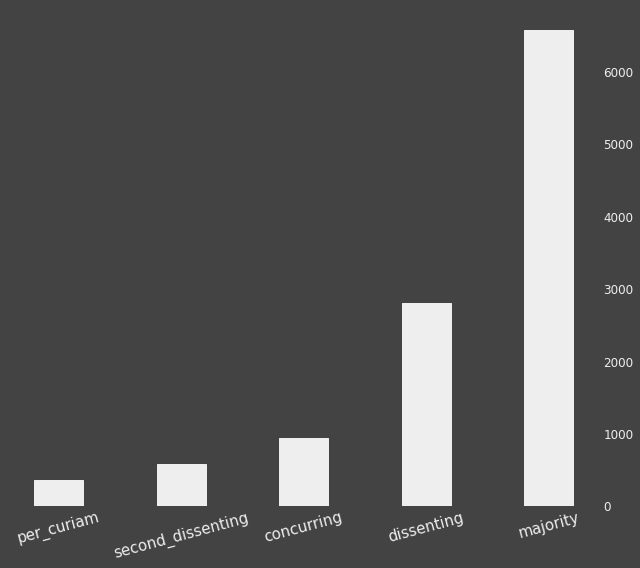

In [ ]:
op_type = df_main['fd_category'].value_counts().sort_values(ascending = False)
op_type.sort_values(inplace = True)

fig,ax = plt.subplots(
    figsize=(9,8),
    facecolor='#434343')

ax.set_facecolor('#434343')


ax.bar(
    list(op_type.index),
    op_type,
    facecolor='#eeeeee',
    edgecolor='#eeeeee',
    width = 0.4
    )

ax.tick_params(
    axis='x', 
    colors='#eeeeee',
    labelsize=15,
    labelrotation=15,
    length=0
    )

ax.tick_params(
    axis='y', 
    colors='#eeeeee',
    labelsize=12,
    length=0
    )


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)

ax.yaxis.tick_right()

fig.tight_layout()
fig.savefig('images/Opiniontypes.png',facecolor='#434343')

Now lets see how many cases have more than one opinion

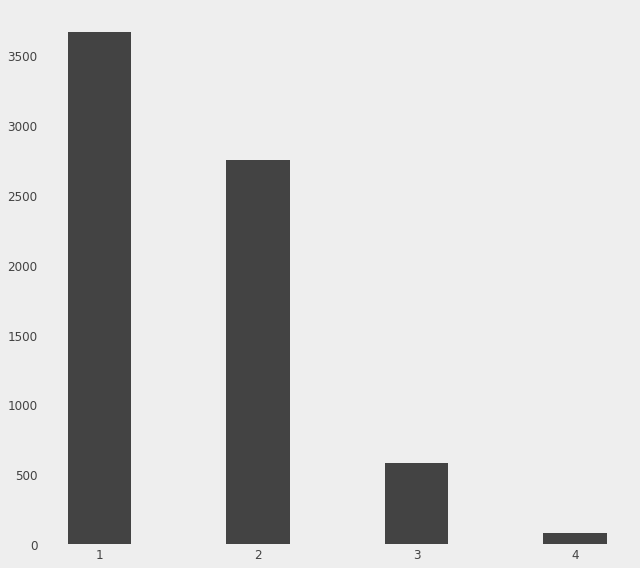

In [ ]:
multi_opinions = df_main['fd_scdb_id'].value_counts().value_counts()

fig,ax = plt.subplots(
    figsize=(9,8),
)

ax.bar(
    list(multi_opinions.index),
    multi_opinions,
    width = 0.4
    )

ax.tick_params(
    axis='both', 
    colors='#434343',
    labelsize=12,
    length=0
    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)

ax.locator_params(integer=True)
fig.tight_layout()
fig.savefig('images/OpinionsPerCase.png',facecolor='#eeeeee')

We see that a little more than half the cases have at least two opinions. This is also in line with our intuition of the corpus of Supreme Court cases; only really contentious matters tend to find their way to the court and being controversial they provoke strong opinions. The maximum number of opinions for any case seems to be 4. Makes sense, it would be hard to split a bench of 9 any finer than that

Given that our objective is the categorize the opinions into areas of law, the fact that a given opinion is a majority, dissenting or concurring is ultimately irrelevant since the subject matter they discuss (and more importantly, the terminology they use), will be the same. Including non majority opinions might simply add noise to our models, so lets drop them

In [ ]:
df_main = df_main[df_main['fd_category'] == 'majority']

## Word counts

Im now curious to see what the most frequently occuring words are in this corpus. Aside from common words like "the" and "it" ofcourse. Lets use scikit-learns CountVectorizer class to see this distribution while leaving out standard stop-words so we can focus on corpus specific terms. 

In [ ]:
countvec = CountVectorizer(stop_words='english')
df_wordcounts= countvec.fit_transform(df_main['fd_text'])

words = countvec.get_feature_names()
sums = df_wordcounts.toarray().sum(axis=0)
count_dict = dict(zip(words,sums))

count_series = pd.Series(count_dict)
count_series.sort_values(ascending = False,inplace=True)

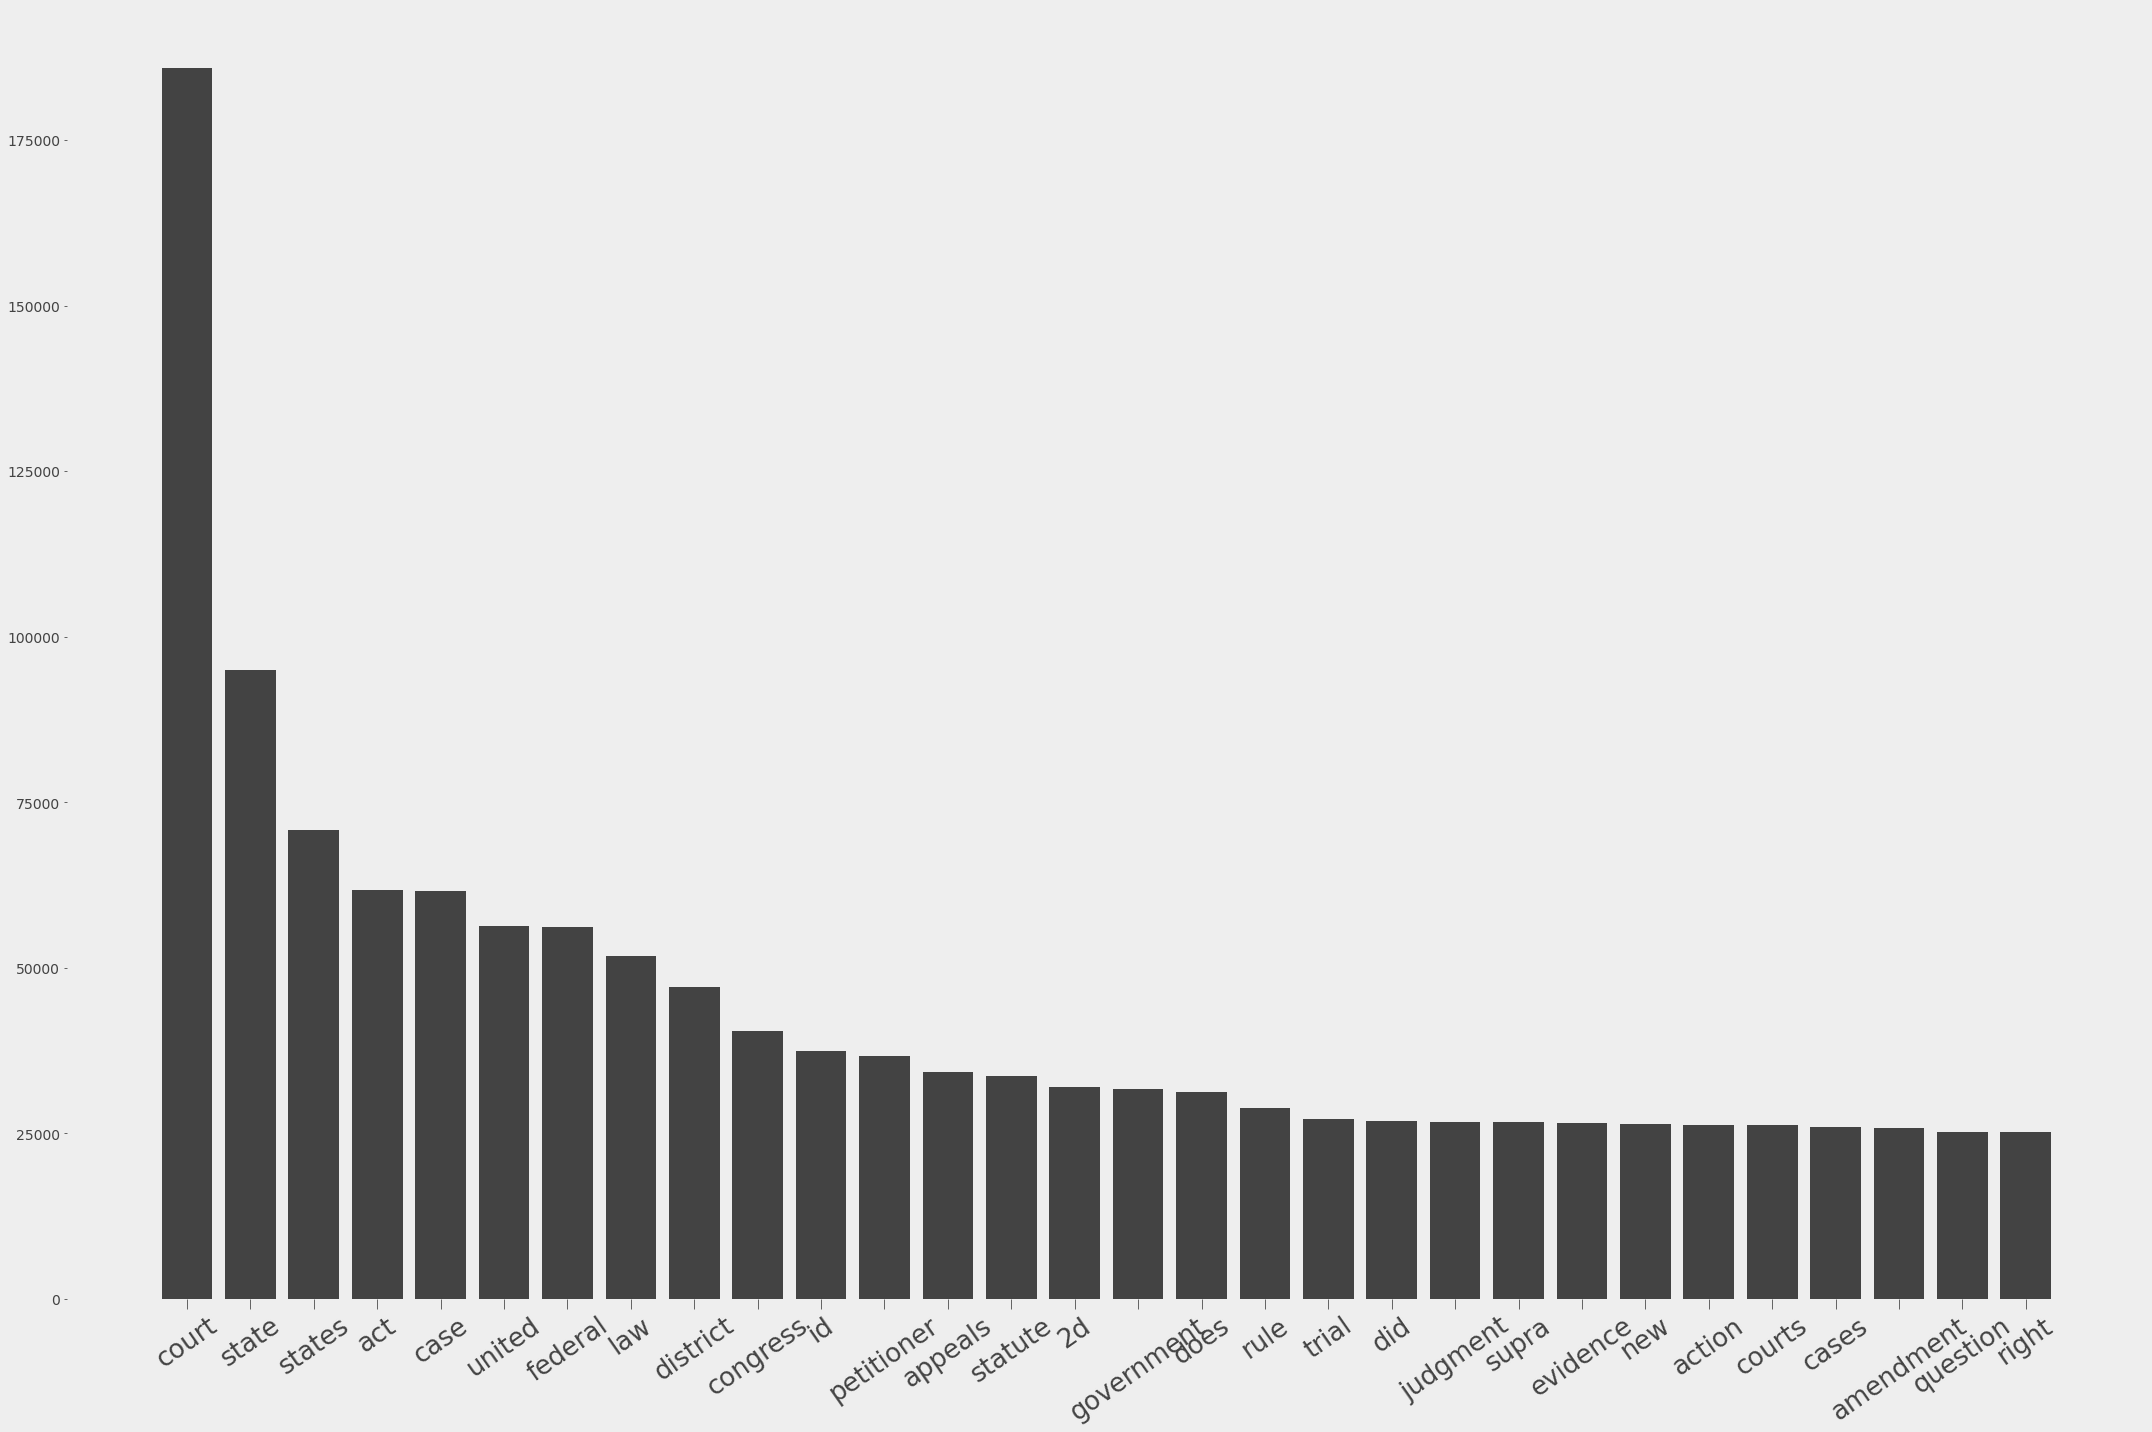

In [ ]:
top_30 = count_series.head(30)

fig,ax = plt.subplots(figsize=(30,20))

ax.tick_params(
    axis='x', 
    labelrotation=35,
    length=10,
    labelsize= 26
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)

ax.bar(list(top_30.index),top_30)

fig.tight_layout()
fig.savefig('images/CommonWords.png',facecolor='#eeeeee')

Again, about exactly what we would expect. "Court" is the most frequently used word by far; hardly a surprise. Court opinions for the most part consist of reviewing previous court precedant to determine where the law stands. This invovles alot of language of the type " The Court in Kramer vs Kramer found that..." or "The Court there held..." etc. The other words are also very much in line with typical legal language found in apellate opinions. 

Lets capture the the top 70 most common words in a list. Later on, we can try removing these when building different models to see if it improves performance. 

In [ ]:
corpus_stopwords = set(count_series.head(70).index)

combined_stopwords = sk_text.ENGLISH_STOP_WORDS.union(corpus_stopwords)


# Topic Modeling

## Latent Dirichlet Allocation()

 It would be interesting to see if the categories in the dataset will align with componenta constructed using LDA. If the categories can be algorithmicly and mathenatically reconstructed, it will serve as an indication that they are sufficiently distinct to be predicted by machine learning and deep learning algorithms.

 We will try different combinations of models and parameters to see which performs best. Lets initialize a report dataframe to keep track of the

In [ ]:
topic_report = pd.DataFrame()
text_column ='fd_text'
lab_column = 'labels'

In [ ]:
descrip = 'no stop words'

n_comps = len(df_main['labels'].value_counts())

model0= TopicModel(
    text_column,lab_column,'lda',n_comps,[],df_main,descrip)

topic_report = topic_report.append(model0.report_row,ignore_index=True)
display(topic_report)

,Accuracy,Description,Model Type,Stop Words
0,0.378559,no stop words,lda,[]


## NMF

Now lets try an NMF model. 

In [ ]:
descrip = 'no stop words'

n_comps = len(df_main['labels'].value_counts())

model1= TopicModel(
    text_column,lab_column,'nmf',n_comps,[],df_main,descrip)

topic_report = topic_report.append(model1.report_row,ignore_index=True)
display(topic_report)

,Accuracy,Description,Model Type,Stop Words
0,0.378559,no stop words,lda,[]
1,0.296178,no stop words,nmf,[]


## Regular Stopwords

We saw that an LDA model performed best. Lets fit an LDA with regular english stopwords. 

In [ ]:
descrip = 'english words'

n_comps = len(df_main['labels'].value_counts())

model2 = TopicModel(
    text_column,lab_column,'lda',n_comps,'english',df_main,descrip)

topic_report = topic_report.append(model2.report_row,ignore_index=True)
display(topic_report)

,Accuracy,Description,Model Type,Stop Words
0,0.378559,no stop words,lda,[]
1,0.296178,no stop words,nmf,[]
2,0.283691,english words,lda,english


## Most common words

Now lets remove the 70 most common words in the corpus only. 

In [ ]:
descrip = 'Most common removed'

n_comps = len(df_main['labels'].value_counts())

model3 = TopicModel(
    text_column,lab_column,'lda',n_comps,corpus_stopwords,df_main,descrip)

topic_report = topic_report.append(model3.report_row,ignore_index=True)
display(topic_report)

,Accuracy,Description,Model Type,Stop Words
0,0.378559,no stop words,lda,[]
1,0.296178,no stop words,nmf,[]
2,0.283691,english words,lda,english
3,0.345820,Most common removed,lda,"{state, jury, criminal, judge, justice, petiti..."


##  Remove English and Common words. 

Now lets remove both regular english stopwords as well as the most common words in the corpus

In [ ]:
descrip = 'english and common stopwords'

n_comps = len(df_main['labels'].value_counts())

model4 = TopicModel(
    text_column,lab_column,'lda',n_comps,combined_stopwords,df_main,descrip)

topic_report = topic_report.append(model4.report_row,ignore_index=True)
display(topic_report)

,Accuracy,Description,Model Type,Stop Words
0,0.378559,no stop words,lda,[]
1,0.296178,no stop words,nmf,[]
2,0.283691,english words,lda,english
3,0.345820,Most common removed,lda,"{state, jury, criminal, judge, justice, petiti..."
4,0.399878,english and common stopwords,lda,"(state, between, which, bill, whose, each, bec..."


## Reduced labels

Maybe if we remove the low occuring labels, it might help performance on the remaining labels. Lets remove labels that occur less than 90 times in the dataset. 

In [ ]:
label_counts = df_main['labels'].value_counts()
high_labels = list(label_counts[label_counts > 90].index)
df_lowercats = df_main[df_main['labels'].isin(high_labels)]

Now lets fit the model.

In [ ]:
descrip = 'LDA, Most common removed'

n_tops = len(high_labels)

model5 = TopicModel(text_column,lab_column,'lda',n_tops,'english',df_lowercats)

topic_report = topic_report.append(model5.report_row,ignore_index=True)
display(topic_report)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Accuracy,Description,Model Type,Stop Words
0,0.378559,no stop words,lda,[]
1,0.296178,no stop words,nmf,[]
2,0.283691,english words,lda,english
3,0.345820,Most common removed,lda,"{state, jury, criminal, judge, justice, petiti..."
4,0.399878,english and common stopwords,lda,"(state, between, which, bill, whose, each, bec..."
5,0.295858,None,lda,english


# Machine Learning classification

We will now try various machine learning techniques to try and predict the label for each opinion. 

The 'Refiner' class, found in the datashop_classes.py file in the root directory, is a convenience class that will help us gather metrics for each model in one location to assess best performance. 

In [ ]:
X = df_main['fd_text']
y = df_main['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42)
 
ref = Refinery(X,y)

## Random Forest

In [ ]:
info = {
    'description':'Base Random Forest'
}

rfc = Pipeline([('cvect', CountVectorizer()),
                ('clf', RandomForestClassifier()),
])

ref.ingest(rfc,info)

,description,f1_score,accuracy,Model,Vectorizer
0,Base Random Forest,0.615125,0.665447,RandomForestClassifier,CountVectorizer


## K-Nearest Neighbors




In [ ]:
info = {
    'description':'base KNN'
}

knn = Pipeline([('cvect', CountVectorizer()),
                ('clf', KNeighborsClassifier()),
])

ref.ingest(rfc,info)

,description,f1_score,accuracy,Model,Vectorizer
0,Base Random Forest,0.615125,0.665447,RandomForestClassifier,CountVectorizer
1,base KNN,0.609760,0.660729,RandomForestClassifier,CountVectorizer




##Multinomial Naive Bayes

In [ ]:

info = {
    'description':'Base MNB'
}

mnb = Pipeline([('cvect', CountVectorizer()),
                ('clf', MultinomialNB()),
])

ref.ingest(mnb,info)

,description,f1_score,accuracy,Model,Vectorizer
0,Base Random Forest,0.615125,0.665447,RandomForestClassifier,CountVectorizer
1,base KNN,0.609760,0.660729,RandomForestClassifier,CountVectorizer
2,Base MNB,0.757261,0.766403,MultinomialNB,CountVectorizer


## Linear Support Vector Machines

In [ ]:
info = {
    'description':'Base SupVector'
}

lsvc = Pipeline([('cvect', CountVectorizer()),
                 ('clf', LinearSVC()),
])


ref.ingest(lsvc,info)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,description,f1_score,accuracy,Model,Vectorizer
0,Base Random Forest,0.615125,0.665447,RandomForestClassifier,CountVectorizer
1,base KNN,0.609760,0.660729,RandomForestClassifier,CountVectorizer
2,Base MNB,0.757261,0.766403,MultinomialNB,CountVectorizer
3,Base SupVector,0.769570,0.773106,LinearSVC,CountVectorizer


## Best Model

It appears SVC is the best performing model. Lets try different adjustments to see if we can improve performance. 

First lets use a TFIDF vectorizer instead of CountVectorizer. 

In [ ]:
info = {
    'description':'Sup Vec with TFIDF'
}

lsvc_tfidf = Pipeline([('count', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

ref.ingest(lsvc_tfidf,info)

,description,f1_score,accuracy,Model,Vectorizer
0,Base Random Forest,0.615125,0.665447,RandomForestClassifier,CountVectorizer
1,base KNN,0.609760,0.660729,RandomForestClassifier,CountVectorizer
2,Base MNB,0.757261,0.766403,MultinomialNB,CountVectorizer
3,Base SupVector,0.769570,0.773106,LinearSVC,CountVectorizer
4,Sup Vec with TFIDF,0.796732,0.804168,LinearSVC,TfidfVectorizer


That seems to have improved performance. 

Now lets Remove stock stop words

In [ ]:
info = {
    'description':'SVC/TFIDF and english stopwords',
    'stopwords':'english'
}

lsvc_eng = Pipeline([('tfidf', TfidfVectorizer(stop_words=info['stopwords'])),
                     ('clf', LinearSVC()),
])

ref.ingest(lsvc_eng,info)

,description,f1_score,accuracy,Model,Vectorizer,stopwords
0,Base Random Forest,0.615125,0.665447,RandomForestClassifier,CountVectorizer,NaN
1,base KNN,0.609760,0.660729,RandomForestClassifier,CountVectorizer,NaN
2,Base MNB,0.757261,0.766403,MultinomialNB,CountVectorizer,NaN
3,Base SupVector,0.769570,0.773106,LinearSVC,CountVectorizer,NaN
4,Sup Vec with TFIDF,0.796732,0.804168,LinearSVC,TfidfVectorizer,NaN
5,SVC/TFIDF and english stopwords,0.800557,0.806453,LinearSVC,TfidfVectorizer,english


Now we will take out just the most common words in the corpus (aside from standard English stopwords)

In [ ]:
info = {
    'description':'SVC/TFIDF and common stopwords',
    'stopwords':'Most Common Words'
}

lsvc_mystopwords = Pipeline(
    [
     ('tfidf', TfidfVectorizer(stop_words=corpus_stopwords)),
    ('clf', LinearSVC()),
])

ref.ingest(lsvc_mystopwords,info)

,description,f1_score,accuracy,Model,Vectorizer,stopwords
0,Base Random Forest,0.615125,0.665447,RandomForestClassifier,CountVectorizer,NaN
1,base KNN,0.609760,0.660729,RandomForestClassifier,CountVectorizer,NaN
2,Base MNB,0.757261,0.766403,MultinomialNB,CountVectorizer,NaN
3,Base SupVector,0.769570,0.773106,LinearSVC,CountVectorizer,NaN
4,Sup Vec with TFIDF,0.796732,0.804168,LinearSVC,TfidfVectorizer,NaN
5,SVC/TFIDF and english stopwords,0.800557,0.806453,LinearSVC,TfidfVectorizer,english
6,SVC/TFIDF and common stopwords,0.794210,0.802187,LinearSVC,TfidfVectorizer,Most Common Words


Lastly, lets take out both english and common words. 

In [ ]:
info = {
    'description':'SVC/TFIDF combined stopwords',
    'stopwords':'English + Most Common Words'
}

lsvc_mystopwords = Pipeline(
    [
     ('tfidf', TfidfVectorizer(stop_words=combined_stopwords)),
    ('clf', LinearSVC()),
])

ref.ingest(lsvc_mystopwords,info)

,description,f1_score,accuracy,Model,Vectorizer,stopwords
0,Base Random Forest,0.615125,0.665447,RandomForestClassifier,CountVectorizer,NaN
1,base KNN,0.609760,0.660729,RandomForestClassifier,CountVectorizer,NaN
2,Base MNB,0.757261,0.766403,MultinomialNB,CountVectorizer,NaN
3,Base SupVector,0.769570,0.773106,LinearSVC,CountVectorizer,NaN
4,Sup Vec with TFIDF,0.796732,0.804168,LinearSVC,TfidfVectorizer,NaN
5,SVC/TFIDF and english stopwords,0.800557,0.806453,LinearSVC,TfidfVectorizer,english
6,SVC/TFIDF and common stopwords,0.794210,0.802187,LinearSVC,TfidfVectorizer,Most Common Words
7,SVC/TFIDF combined stopwords,0.794670,0.801275,LinearSVC,TfidfVectorizer,English + Most Common Words


## Word Vectors

I'm curious to see if we can generate word vectors that accurately capture relationships between words. Lets generate some now. 

In [ ]:
data_tokens = df_main['fd_text'].map(word_tokenize)

target= df_main['labels']

model = Word2Vec(data_tokens,size=100,window=7,min_count=1,workers=4)

model.train(data_tokens,total_examples=model.corpus_count,epochs=10)

wv = model.wv

Lets see if they word vectors are accurately capturing associations between words in the corpus. 

In [ ]:
wv.most_similar('speech')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('expression', 0.8534947633743286),
 ('expressive', 0.6627659797668457),
 ('ideas', 0.6603418588638306),
 ('speakers', 0.6532744765281677),
 ('censorship', 0.6498188376426697),
 ('advertising', 0.6173608303070068),
 ('privacy', 0.613409161567688),
 ('content', 0.6084858179092407),
 ('press', 0.6069868803024292),
 ('associational', 0.6048232913017273)]

Right no point. We would absolutely expect the word "speech" to occure near words like "expression" and "censorship". 

## GloVe

Lets see what kind of performance we can get using the pre-trained GloVe model to classify our dataset. We will use the Wikipedia Gigawords dataset, available [here](https://nlp.stanford.edu/projects/glove/).


In [ ]:
import zipfile 
with zipfile.ZipFile('glove/glove.6B.zip','r') as zip_ref:
    zip_ref.extractall("glove")

Now lets compile a set of all the unique words in our corpus. Then, we will gather gather vectors for just those words from the GloVe set. 

In [ ]:
total_vocabulary = set(word for doc in data_tokens for word in doc) - combined_stopwords

glove = {}
with open('glove/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [ ]:
len(total_vocabulary)

200668

The following class with return the Mean Embedding for all the vectors in a given opinion. 

In [ ]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    

    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

Now lets build a set of pipelines that will create a Word2Vec vectorizer for the glove vectors and fit different models to the data. We will fit and train and get cross validation scores. 

In [ ]:
info = {
    'description':'Custom W2V with Glove',
    'stopwords':'english'
}

svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', LinearSVC())])


f1_score = cross_val_score(
    svc, data_tokens, target, cv=4,scoring='f1_weighted').mean()

acc_score = cross_val_score(
    svc, data_tokens, target, cv=4,scoring='balanced_accuracy').mean()

w2v_dict ={
        'description':'Glove',
        'Model':'LinearSVC',
        'Vectorizer':'customW2V class',
        'accuracy':acc_score,
        'f1_score':f1_score
    }

report = ref.report
report = report.append(w2v_dict,ignore_index=True)

# Deep Learning Model

And now, lets fit and train a deep learning model and see how well it performs in classifying out text. 

We will first tokenize our text and create padded sequences, and also one hot encode our target variables. 

In [ ]:
tokenizer = text.Tokenizer(num_words=len(total_vocabulary))
tokenizer.fit_on_texts(list(df_main['fd_text']))
list_tokenized_docs = tokenizer.texts_to_sequences(df_main['fd_text'])

X = sequence.pad_sequences(list_tokenized_docs, maxlen=8000)
y = pd.get_dummies(target).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Now lets set up our deep learning model.

We will add callbacks that will stop training the model when it ceases to see an improvement in the accuracy score of the validation set and return the best performing model. 

The model will continue for 1500 epochs unless the callbacks stop the training.

In [ ]:
model = Sequential()
embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])

es = EarlyStopping(
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1,
    patience=10,)

mc = ModelCheckpoint(
    'best_deep_model.h5',
    monitor='val_categorical_accuracy',
    mode='min',
    save_best_only=True,verbose=1)

cb = [es,mc]

history = model.fit(
            X_train, 
            y_train, 
            epochs=300, 
            batch_size=32, 
            validation_split=0.1,
            callbacks = cb
            )

Epoch 1/300
124/124 [==============================] - ETA: 0s - loss: 2.3157 - categorical_accuracy: 0.2018
Epoch 00001: val_categorical_accuracy improved from inf to 0.37045, saving model to best_deep_model.h5
124/124 [==============================] - 52s 421ms/step - loss: 2.3157 - categorical_accuracy: 0.2018 - val_loss: 2.1544 - val_categorical_accuracy: 0.3705
Epoch 2/300
124/124 [==============================] - ETA: 0s - loss: 2.1105 - categorical_accuracy: 0.2730
Epoch 00002: val_categorical_accuracy did not improve from 0.37045
124/124 [==============================] - 50s 399ms/step - loss: 2.1105 - categorical_accuracy: 0.2730 - val_loss: 1.8654 - val_categorical_accuracy: 0.4045
Epoch 3/300
124/124 [==============================] - ETA: 0s - loss: 1.8985 - categorical_accuracy: 0.3801
Epoch 00003: val_categorical_accuracy did not improve from 0.37045
124/124 [==============================] - 49s 399ms/step - loss: 1.8985 - categorical_accuracy: 0.3801 - val_loss: 1.67

Now lets plot the model performance to get an idea of when it starts to overfit. 

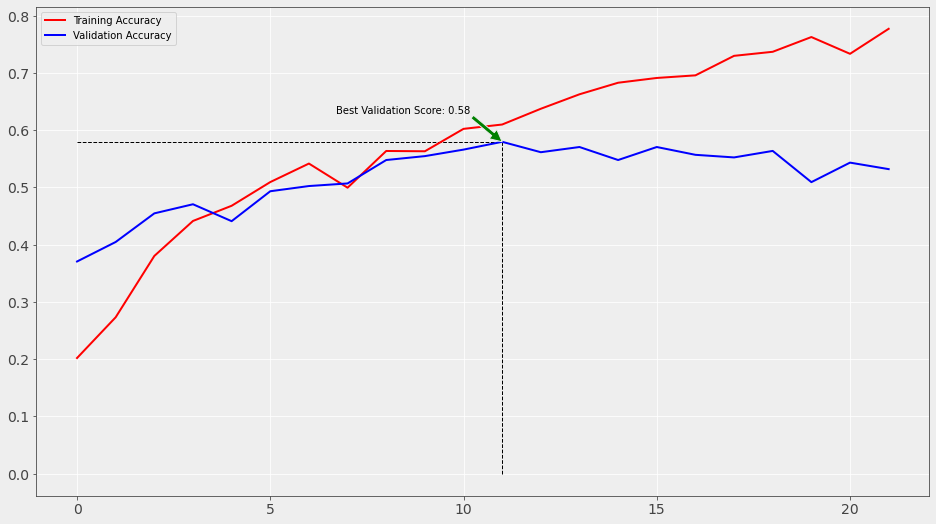

In [ ]:
fig,ax = plt.subplots()

cat_acc, = ax.plot(
    history.history['categorical_accuracy'],
    linewidth = 2,
    color='r',
    label = 'Training Accuracy'
)

val_acc, = ax.plot(
    history.history['val_categorical_accuracy'],
    linewidth = 2,
    color='b',
    label='Validation Accuracy'
    )

ax.legend(handles=[cat_acc,val_acc])


cat_max = history.history['val_categorical_accuracy']
a1_x = cat_max.index(max(cat_max))
a1_y= max(cat_max)

ax.hlines(a1_y,xmin=0,xmax=a1_x,linestyles='dashed')
ax.vlines(a1_x,ymin=0,ymax=a1_y,linestyles='dashed')

ax.annotate(
    'Best Validation Score: {}'.format(round(max(cat_max),3)),
    (a1_x,a1_y),
    xytext=(a1_x-4.3,a1_y+0.05),
    arrowprops = {
        'facecolor':'green'
    }
    )

fig.savefig('images/DeepLearningScoreChart.png')

Lets also add the results of the deep learning model to the classification report. 

In [ ]:
deep_row ={
            'description':'Neural Net',
            'Model':'NeuralNet',
            'Vectorizer':'padded_sequence',
            'f1_score':a1_y
        }
report = report.append(deep_row,ignore_index=True)

It seems our neural network maxes out accuracy on the training sets at 0.65. This is worse than our SVC model.  

# Conclusion

In [ ]:
report = report.sort_values(by='f1_score',ascending=False)
display(report)

report.to_csv('data/ModelPerformance')

,description,f1_score,accuracy,Model,Vectorizer,stopwords
5,SVC/TFIDF and english stopwords,0.800557,0.806453,LinearSVC,TfidfVectorizer,english
4,Sup Vec with TFIDF,0.796732,0.804168,LinearSVC,TfidfVectorizer,NaN
7,SVC/TFIDF combined stopwords,0.794670,0.801275,LinearSVC,TfidfVectorizer,English + Most Common Words
6,SVC/TFIDF and common stopwords,0.794210,0.802187,LinearSVC,TfidfVectorizer,Most Common Words
3,Base SupVector,0.769570,0.773106,LinearSVC,CountVectorizer,NaN
2,Base MNB,0.757261,0.766403,MultinomialNB,CountVectorizer,NaN
0,Base Random Forest,0.615125,0.665447,RandomForestClassifier,CountVectorizer,NaN
1,base KNN,0.609760,0.660729,RandomForestClassifier,CountVectorizer,NaN
8,Glove,0.588545,0.403795,LinearSVC,customW2V class,NaN
9,Neural Net,0.579545,NaN,NeuralNet,padded_sequence,NaN


From the results of our project, it appears that the best classification performance achieved by us has been by use of Support Vector Machines. That model was able to achieve an f1 score of 0.8.  This is very good performance. 

Our deep learning model did not perform so well on the validation sets. Its probably because we dont really have a large enough number of examples for each class. 

Nonetheless, it seems that using machine learning to classify opinions into areas of law is a very feasible proposition. 

# Future Work:

1. __<ins>Train on cases from other courts and jurisdictions:__

    We saw that our deep learning model did not perform all that well. Its is possible that if we were to add additional opinions into the training set we might get performance even better than what we got with SVC. 

2. __<ins>Use advanced pre-trained models such BERT:__

    We may have more luck with the most cutting edge pre-trained models like Google's BERT. 

2. __<ins>Predict other targets:__

    It might be worthwhile to predict other features as well. 

    It would be interesting to see if we could analyse the opinions written by a given judge, or their vote on a given opinion in order to model their voting tendencies and predict how they may vote on a matter. The 'weights' of such a model could serve as a mathematical representation of idealogical positions perhaps. 

    Such a model could prove highly useful to developing litigation strategy. It would, however, be a data engineering challenge. We would probably have to obtain the full texts of complaints or petitions in addition to final judgements and opinions.

# GOOGLE STUFF